# Project Benson

## Exploring... and Aggregating

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import seaborn as sns
from numpy import linalg

import math
import patsy

from statsmodels.formula.api import ols

import datetime

%matplotlib inline

/home/joseph/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
!python -V

Python 3.6.3 :: Anaconda custom (64-bit)


In [3]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.3
Numpy version: 1.13.3


## Data input



In [4]:

# Specify location to store dataframes
mydir = '/home/joseph/ds/Projects/Project_Benson/Data'

name = '2017_3mo'

df_pickle = '%s/turnstile_%s.pkl' % (mydir,name)
hourly_pickle = '%s/turnstile_%s_hourly.pkl' % (mydir,name)

Or, if desired, read in previous work...

In [5]:
df = pd.read_pickle(df_pickle, compression='gzip')
hourly = pd.read_pickle(hourly_pickle, compression='gzip')

## Data Aggregation

In [6]:
df.head()

C/A LINE NAME DIVISION  \
UNIT SCP      STATION DATE_TIME                                      
R051 02-00-00 59 ST   2017-03-01 03:00:00  A002   NQR456W      BMT   
                      2017-03-01 07:00:00  A002   NQR456W      BMT   
                      2017-03-01 11:00:00  A002   NQR456W      BMT   
                      2017-03-01 15:00:00  A002   NQR456W      BMT   
                      2017-03-01 19:00:00  A002   NQR456W      BMT   

                                          DESCRIPTION  ENTRIES    EXITS  
UNIT SCP      STATION DATE_TIME                                          
R051 02-00-00 59 ST   2017-03-01 03:00:00     REGULAR  6069098  2057720  
                      2017-03-01 07:00:00     REGULAR  6069123  2057764  
                      2017-03-01 11:00:00     REGULAR  6069277  2058110  
                      2017-03-01 15:00:00     REGULAR  6069516  2058196  
                      2017-03-01 19:00:00     REGULAR  6070303  2058286

In [7]:
hourly['TOTAL'] = hourly['ENTRIES'] + hourly['EXITS']

In [8]:
hourly.tail()

ENTRIES  EXITS   TOTAL
UNIT SCP      STATION     DATE_TIME                                  
R572 01-03-04 96 ST-2 AVE 2017-05-31 17:00:00    78.75  17.50   96.25
                          2017-05-31 18:00:00    77.25  47.75  125.00
                          2017-05-31 19:00:00    77.25  47.75  125.00
                          2017-05-31 20:00:00    77.25  47.75  125.00
                          2017-05-31 21:00:00    77.25  47.75  125.00

In [9]:
def resampler(x):
    """ A function to resample time series data - to be used in groupby apply."""
    return (x.set_index('DATE_TIME')       # Resample based on our timestamp
            .resample('4H')                # Set the desired time period here
            .sum()                         # The aggregate function used to create the new sampled rows.
           )  
(hourly
 .reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(resampler)
 .head()
)

ENTRIES   EXITS   TOTAL
UNIT SCP      STATION         DATE_TIME                                   
R001 00-00-00 WHITEHALL S-FRY 2017-03-01 00:00:00     0.00    0.00    0.00
                              2017-03-01 04:00:00   187.50   24.75  212.25
                              2017-03-01 08:00:00   627.25   79.50  706.75
                              2017-03-01 12:00:00   501.00  131.75  632.75
                              2017-03-01 16:00:00   441.00  375.75  816.75

## Let's first look at the total aggregate over all 3 months

In [10]:
aggregate = hourly.groupby('STATION').sum()

In [11]:
aggregate['TOTAL'] = aggregate['ENTRIES'] + aggregate['EXITS']

In [12]:
aggregate.sort_values('TOTAL',ascending=False).head(10)

,ENTRIES,EXITS,TOTAL
STATION,,,
34 ST-PENN STA,1.325654e+07,1.133187e+07,2.458841e+07
GRD CNTRL-42 ST,1.159893e+07,1.024549e+07,2.184443e+07
34 ST-HERALD SQ,1.024411e+07,8.988547e+06,1.923266e+07
23 ST,9.770441e+06,7.103302e+06,1.687374e+07
14 ST-UNION SQ,8.760437e+06,7.455541e+06,1.621598e+07
TIMES SQ-42 ST,8.223331e+06,7.470389e+06,1.569372e+07
42 ST-PORT AUTH,8.486818e+06,6.156102e+06,1.464292e+07
FULTON ST,7.267795e+06,6.093252e+06,1.336105e+07
86 ST,7.150966e+06,5.960155e+06,1.311112e+07


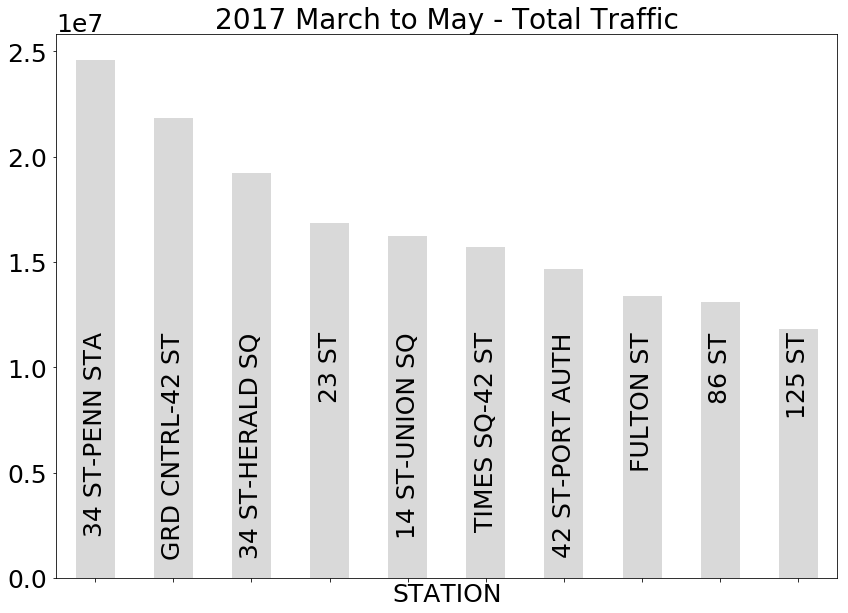

In [13]:
fig=plt.figure(figsize=(14,10))
sns.set_context("paper", rc={"font.size":28,
                             "axes.titlesize":28,
                             "axes.labelsize":25,
                             #"lines.markersize":25,
                             "xtick.labelsize":25,
                             "ytick.labelsize":25,
                            })

ax=(aggregate.sort_values('TOTAL',ascending=False)['TOTAL'].head(10)
.plot(kind='bar',color=(0.85,0.85,0.85),title="2017 March to May - Total Traffic")
)
ax.tick_params(axis='x', pad=-250)

In [14]:
 
days =(hourly
 .reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(lambda x: x.set_index('DATE_TIME').resample('1D').sum())
)

In [15]:
days.sort_values('TOTAL',ascending=False)['TOTAL'].head(10)

UNIT  SCP       STATION          DATE_TIME 
R540  02-01-04  PATH NEW WTC     2017-03-23    42551.720930
                                 2017-03-21    42551.720930
                                 2017-03-19    42551.720930
                                 2017-03-18    42551.720930
                                 2017-03-22    42551.720930
                                 2017-03-20    42551.720930
                                 2017-03-24    42551.720930
R546  00-00-00  PAVONIA/NEWPORT  2017-03-08    24653.144891
R012  03-06-00  34 ST-PENN STA   2017-05-17    24544.180412
R546  00-00-00  PAVONIA/NEWPORT  2017-03-09    24283.004046
Name: TOTAL, dtype: float64

In [16]:
datetime.datetime(2017,4,5)

datetime.datetime(2017, 4, 5, 0, 0)

In [17]:
hourly.reset_index(inplace=True)

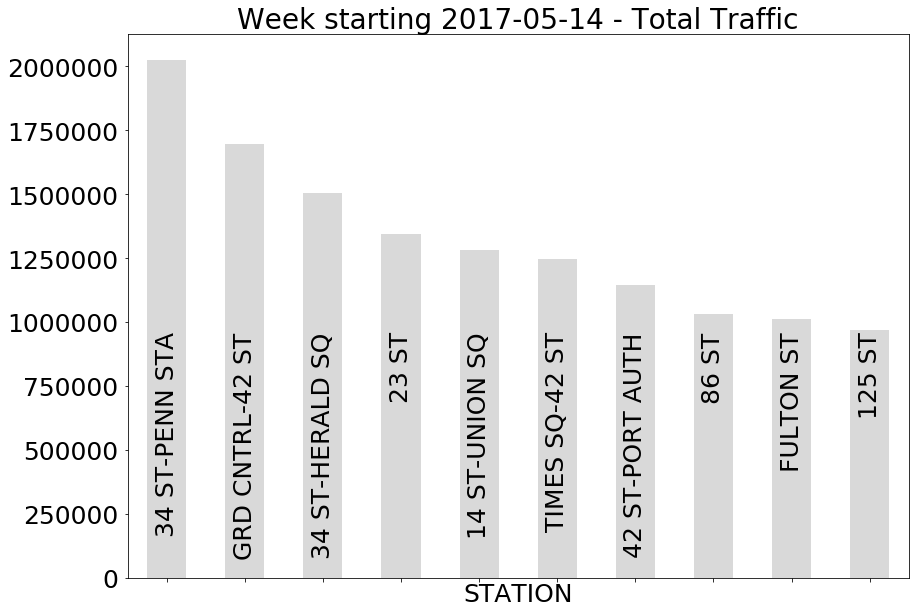

In [18]:
fig=plt.figure(figsize=(14,10))
sns.set_context("paper", rc={"font.size":28,
                             "axes.titlesize":28,
                             "axes.labelsize":25,
                             #"lines.markersize":25,
                             "xtick.labelsize":25,
                             "ytick.labelsize":25,
                            })

mask = (hourly['DATE_TIME'] > datetime.datetime(2017,5,14)) & \
        (hourly['DATE_TIME'] <= datetime.datetime(2017,5,21))

ax = (hourly.loc[mask]
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)['TOTAL']
 .head(10)
 .plot(kind='bar',
       color=(0.85,0.85,0.85),
       title="Week starting 2017-05-14 - Total Traffic")
)
ax.tick_params(axis='x', pad=-250)

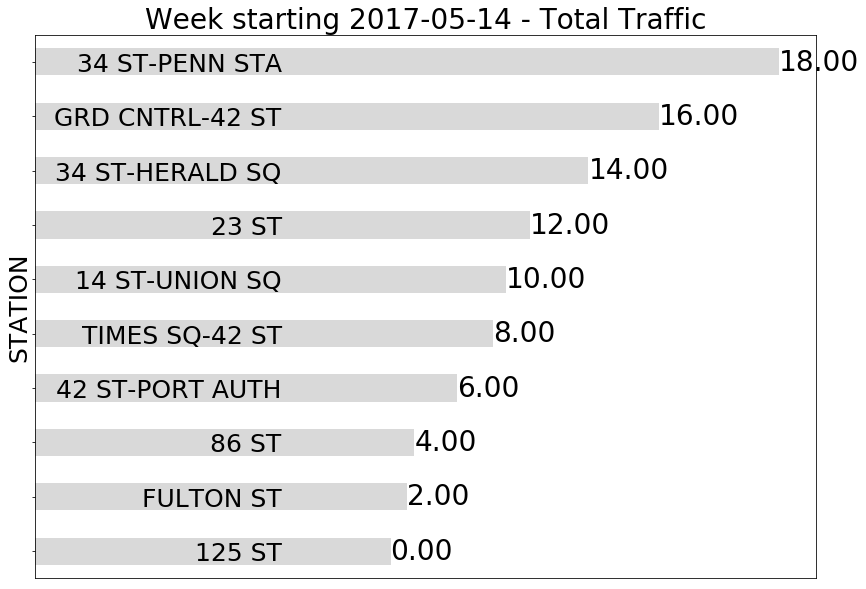

In [19]:
fig=plt.figure(figsize=(14,10))
sns.set_context("paper", rc={"font.size":28,
                             "axes.titlesize":28,
                             "axes.labelsize":25,
                             #"lines.markersize":25,
                             "xtick.labelsize":25,
                             "ytick.labelsize":25,
                            })

mask = (hourly['DATE_TIME'] > datetime.datetime(2017,5,14)) & \
        (hourly['DATE_TIME'] <= datetime.datetime(2017,5,21))

ax = (hourly.loc[mask]
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)['TOTAL']
 .head(10)
 .sort_values(ascending=True)
 .plot(kind='barh',
       color=(0.85,0.85,0.85),
       title="Week starting 2017-05-14 - Total Traffic")
)

# The magic that slides the station name into the bar
ax.tick_params(axis='y', pad=-250)

# The magic that gets rid of the numbers below
ax.get_xaxis().set_ticks([])

x_offset = 2.5
y_offset = 0.1
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1) + x_offset, b.y0 + y_offset))


I believe it will help to change the programming flow here a bit...

TOTAL    966762.5
Name: 125 ST, dtype: float64
TOTAL    1011116.25
Name: FULTON ST, dtype: float64
TOTAL    1031189.0
Name: 86 ST, dtype: float64
TOTAL    1146470.5
Name: 42 ST-PORT AUTH, dtype: float64
TOTAL    1245044.0
Name: TIMES SQ-42 ST, dtype: float64
TOTAL    1280332.75
Name: 14 ST-UNION SQ, dtype: float64
TOTAL    1345116.25
Name: 23 ST, dtype: float64
TOTAL    1504955.25
Name: 34 ST-HERALD SQ, dtype: float64
TOTAL    1.697261e+06
Name: GRD CNTRL-42 ST, dtype: float64
TOTAL    2023883.0
Name: 34 ST-PENN STA, dtype: float64


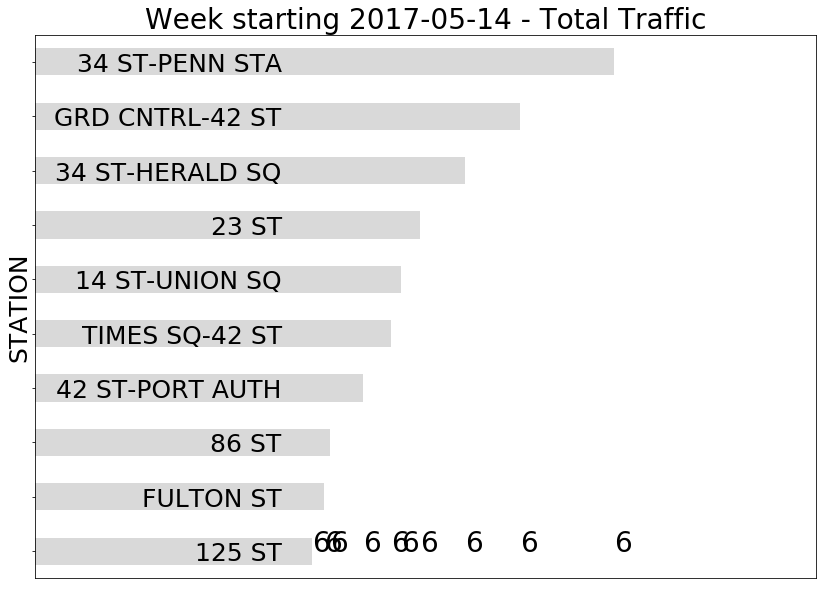

In [37]:
fig=plt.figure(figsize=(14,10))
sns.set_context("paper", rc={"font.size":28,
                             "axes.titlesize":28,
                             "axes.labelsize":25,
                             #"lines.markersize":25,
                             "xtick.labelsize":25,
                             "ytick.labelsize":25,
                            })

mask = (hourly['DATE_TIME'] >  datetime.datetime(2017,5,14)) & \
       (hourly['DATE_TIME'] <= datetime.datetime(2017,5,21))

finding = (hourly.loc[mask]
 .groupby('STATION').sum()
 #.reset_index()
 .sort_values('TOTAL',ascending=False)[['TOTAL']]
 .head(10)
 .sort_values('TOTAL',ascending=True)
)

ax = (finding['TOTAL'].plot(kind='barh',
       color=(0.85,0.85,0.85),
       title="Week starting 2017-05-14 - Total Traffic")
)
plt.margins(0.35, 0.1)

# The magic that slides the station name into the bar
ax.tick_params(axis='y', pad=-250)

# The magic that gets rid of the numbers below
ax.get_xaxis().set_ticks([])

def annotateBars(row, ax=ax):
    """ Place the value text on the bar in a bar plot"""
    
    padding = 2
    #print(id(ax))
    
    #print(type(row))
    #print(row['TOTAL'])
    print(row)
    ax.text(row['TOTAL'],0,6)
    #ax.text(row['TOTAL'] + padding, row.name, "{:.1f}".format(row['TOTAL']))

#print(id(ax))
junk = finding.apply(annotateBars, ax=ax, axis=1)



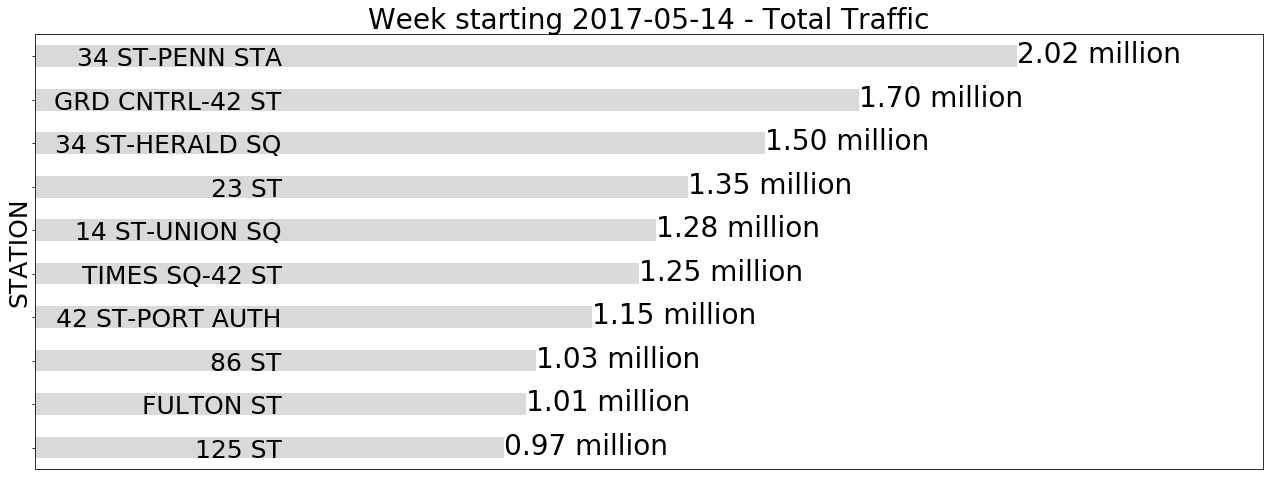

In [194]:
fig=plt.figure(figsize=(22,8))
sns.set_context( rc={"font.size":28,
                             "axes.titlesize":28,
                             "axes.labelsize":25,
                             #"lines.markersize":25,
                             "xtick.labelsize":25,
                             "ytick.labelsize":25,
                            })

mask = (hourly['DATE_TIME'] > datetime.datetime(2017,5,14)) & \
        (hourly['DATE_TIME'] <= datetime.datetime(2017,5,21))

finding = (hourly.loc[mask]
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)[['TOTAL']]
 .head(10)
 .sort_values('TOTAL',ascending=True)
)

ax = (finding['TOTAL']
 .plot(kind='barh',
       color=(0.85,0.85,0.85),
       title="Week starting 2017-05-14 - Total Traffic")
)
plt.margins(0.25, 0.1)

# The magic that slides the station name into the bar
ax.tick_params(axis='y', pad=-250)

# The magic that gets rid of the numbers below
ax.get_xaxis().set_ticks([])

x_offset = 2.5
y_offset = 0.1
i = 0
for p in ax.patches:
    b = p.get_bbox()
    #val = "{:.2f}".format(b.y1 + b.y0)        
    val = "{:.2f} million".format(finding.iloc[i]['TOTAL']/10**6)        
    ax.annotate(val, ((b.x0 + b.x1) + x_offset, b.y0 + y_offset))
    #print(finding.iloc[i]['TOTAL'])
    i += 1

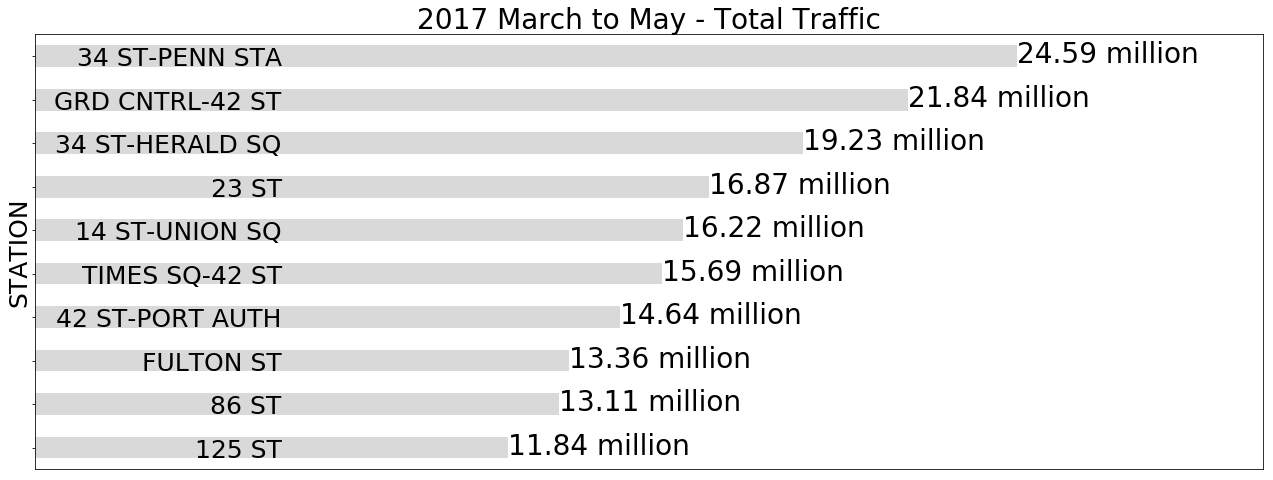

In [193]:
fig=plt.figure(figsize=(22,8))
sns.set_context( rc={"font.size":28,
                             "axes.titlesize":28,
                             "axes.labelsize":25,
                             #"lines.markersize":25,
                             "xtick.labelsize":25,
                             "ytick.labelsize":25,
                            })

mask = (hourly['DATE_TIME'] > datetime.datetime(2017,5,14)) & \
        (hourly['DATE_TIME'] <= datetime.datetime(2017,5,21))

#finding = (hourly.loc[mask]
finding = (hourly.loc[:]
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)[['TOTAL']]
 .head(10)
 .sort_values('TOTAL',ascending=True)
)

ax = (finding['TOTAL']
 .plot(kind='barh',
       color=(0.85,0.85,0.85),
       title="2017 March to May - Total Traffic")
)
plt.margins(0.25, 0.1)

# The magic that slides the station name into the bar
ax.tick_params(axis='y', pad=-250)

# The magic that gets rid of the numbers below
ax.get_xaxis().set_ticks([])

x_offset = 2.5
y_offset = 0.1
i = 0
for p in ax.patches:
    b = p.get_bbox()
    #val = "{:.2f}".format(b.y1 + b.y0)        
    val = "{:.2f} million".format(finding.iloc[i]['TOTAL']/10**6)        
    ax.annotate(val, ((b.x0 + b.x1) + x_offset, b.y0 + y_offset))
    #print(finding.iloc[i]['TOTAL'])
    i += 1

In [64]:
finding = (hourly
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)
)

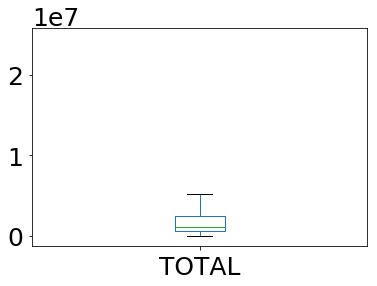

In [79]:
finding['TOTAL'].plot(kind="box")

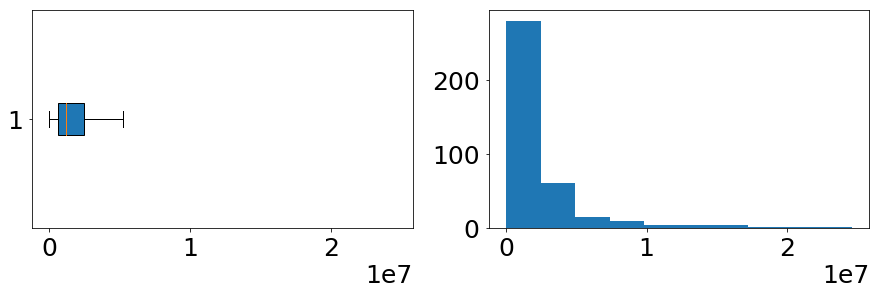

In [100]:
fig=plt.figure(figsize=(15,4))
ax = plt.subplot2grid((1, 2), (0, 0))
bp = ax.boxplot(
    finding['TOTAL'],
    sym='+', vert=False, patch_artist=True)
ax = plt.subplot2grid((1, 2), (0, 1))
bp = ax.hist(
    finding['TOTAL']
)

In [162]:
name_2015 = '2015_3mo'
hourly_2015_pickle = '%s/turnstile_%s_hourly.pkl' % (mydir,name_2015)
hourly_2015 = pd.read_pickle(hourly_2015_pickle, compression='gzip')
name_2016 = '2016_3mo'
hourly_2016_pickle = '%s/turnstile_%s_hourly.pkl' % (mydir,name_2016)
hourly_2016 = pd.read_pickle(hourly_2016_pickle, compression='gzip')

In [163]:
hourly_2015['TOTAL'] = hourly_2015['ENTRIES'] + hourly_2015['EXITS']
hourly_2016['TOTAL'] = hourly_2016['ENTRIES'] + hourly_2016['EXITS']

In [164]:
finding_2015 = (hourly_2015
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)
)
finding_2016 = (hourly_2016
 .groupby('STATION').sum()
 .sort_values('TOTAL',ascending=False)
)

                      ENTRIES         EXITS         TOTAL
STATION                                                  
34 ST-PENN STA   1.325654e+07  1.133187e+07  2.458841e+07
GRD CNTRL-42 ST  1.159893e+07  1.024549e+07  2.184443e+07
34 ST-HERALD SQ  1.024411e+07  8.988547e+06  1.923266e+07
                      ENTRIES         EXITS         TOTAL
STATION                                                  
34 ST-PENN STA   1.375406e+07  1.171693e+07  2.547099e+07
GRD CNTRL-42 ST  1.186180e+07  1.053695e+07  2.239875e+07
34 ST-HERALD SQ  1.001676e+07  8.833056e+06  1.884982e+07
                      ENTRIES         EXITS         TOTAL
STATION                                                  
34 ST-PENN STA   1.420490e+07  1.220754e+07  2.641244e+07
42 ST-GRD CNTRL  1.197383e+07  1.100278e+07  2.297661e+07
34 ST-HERALD SQ  1.012706e+07  9.026213e+06  1.915328e+07


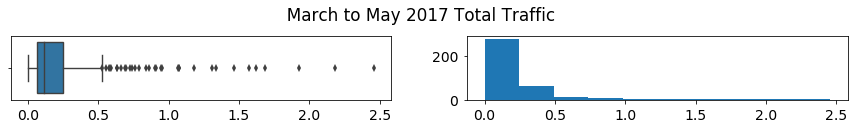

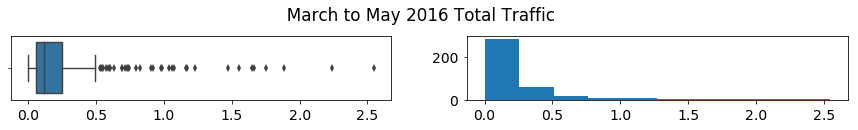

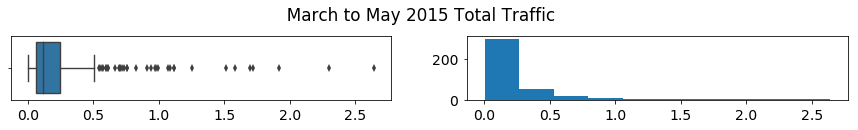

In [186]:
sns.set_context("paper", rc={"font.size":14,
                             "axes.titlesize":28,
                             "axes.labelsize":14,
                             #"lines.markersize":25,
                             "xtick.labelsize":14,
                             "ytick.labelsize":14,
                            })


fig1=plt.figure(figsize=(15,4))
fig1.suppressComposite=False
ax = plt.subplot2grid((3, 2), (0, 0))
bp = sns.boxplot(
    finding['TOTAL'],
    ax=ax
    )
x_values = ax.get_xticks().tolist()
x_values = [x / 1e7 for x in x_values]
ax.set_xticklabels(x_values)

#ax.set_title('Box Plot - March to May Total Traffic')
ax.set_xlabel('')
ax = plt.subplot2grid((3, 2), (0, 1))
bp = ax.hist(
    finding['TOTAL']
)
x_values = ax.get_xticks().tolist()
x_values = [x / 1e7 for x in x_values]
ax.set_xticklabels(x_values)

plt.suptitle('  March to May 2017 Total Traffic',verticalalignment='center',y=0.95 )

fig2=plt.figure(figsize=(15,4))
fig2.suppressComposite=False
ax = plt.subplot2grid((3, 2), (0, 0))
bp = sns.boxplot(
    finding_2016['TOTAL'],
    ax=ax
    )
x_values = ax.get_xticks().tolist()
x_values = [x / 1e7 for x in x_values]
ax.set_xticklabels(x_values)

#ax.set_title('Box Plot - March to May Total Traffic')
ax.set_xlabel('')
ax = plt.subplot2grid((3, 2), (0, 1))
bp = ax.hist(
    finding_2016['TOTAL']
)
x_values = ax.get_xticks().tolist()
x_values = [x / 1e7 for x in x_values]
ax.set_xticklabels(x_values)

plt.suptitle('  March to May 2016 Total Traffic',verticalalignment='center',y=0.95 )



fig2=plt.figure(figsize=(15,4))
fig2.suppressComposite=False
ax = plt.subplot2grid((3, 2), (0, 0))
bp = sns.boxplot(
    finding_2015['TOTAL'],
    ax=ax
    )
x_values = ax.get_xticks().tolist()
x_values = [x / 1e7 for x in x_values]
ax.set_xticklabels(x_values)

#ax.set_title('Box Plot - March to May Total Traffic')
ax.set_xlabel('')
ax = plt.subplot2grid((3, 2), (0, 1))
bp = ax.hist(
    finding_2015['TOTAL']
)
x_values = ax.get_xticks().tolist()
x_values = [x / 1e7 for x in x_values]
ax.set_xticklabels(x_values)

plt.suptitle('  March to May 2015 Total Traffic',verticalalignment='center',y=0.95 )

print(finding.head(3))
print(finding_2016.head(3))
print(finding_2015.head(3))

